In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import logging

from daft_builder import PGM, Plate, Node, Data, Param, HyperParam, Text

logging.basicConfig(level=logging.INFO)

ModuleNotFoundError: No module named 'daft_builder'

## Latent Dirichlet Allocation

As shown in the [Wikipedia article](https://en.wikipedia.org/wiki/Latent_Dirichlet_allocation).

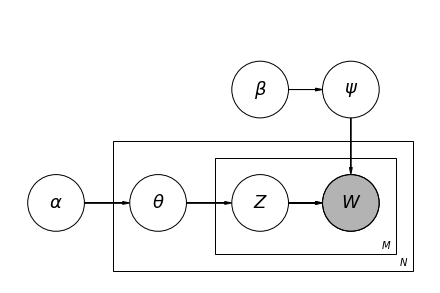

In [3]:
pgm = (PGM()
    .with_plate(Plate(r"$M$")
        .with_nodes(
            Data(r"$W$", xy=(3, 0.7)),
            Param(r"$Z$", left_of="W")))
    .with_plate(Plate(r"$N$")
        .with_nodes(
            Param(r"$\theta$", left_of="Z"),
            "Z", "W"))
    .with_nodes(
        Param(r"$\alpha$", left_of="theta"),
        Param(r"$\psi$", above="W"),
        Param(r"$\beta$", left_of="psi"))
).build()
pgm.render();

## Hierarchical Heteroskedastic Linear Regression

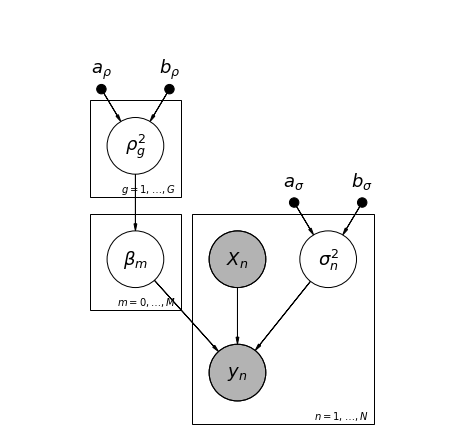

In [6]:
pgm = (PGM()
    .with_plate(Plate(r"$n = 1, \ldots, N$")
        .with_nodes(
            Data(r"$y_n$", xy=(2, 0.5), scale=2),
            Data(r"$X_n$", above="y_n")
                .with_edges_to("y_n"),
            Param(r"$\sigma_n^2$", right_of="X_n", of="y_n")))
    .with_plate(Plate(r"$m = 0, \ldots, M$")
        .with_nodes(
            Param(r"$\beta_m$", left_of="X_n", of="y_n")))
    .with_nodes(
        HyperParam(r"$a_\sigma$", above_l="sigma_n_sq", shift_y=-0.5),
        HyperParam(r"$b_\sigma$", above_r="sigma_n_sq", shift_y=-0.5))
    .with_plate(Plate(r"$g = 1, \ldots, G$")
        .with_nodes(
            Param(r"$\rho_g^2$", above="beta_m")))
    .with_nodes(
        HyperParam(r"$a_\rho$", above_l="rho_g_sq", shift_y=-0.5),
        HyperParam(r"$b_\rho$", above_r="rho_g_sq", shift_y=-0.5))
).build()
pgm.render();

## Probabilistic Matrix Factorization

From [Salakhutdinov and Mnih, 2008](https://papers.nips.cc/paper/3208-probabilistic-matrix-factorization.pdf).

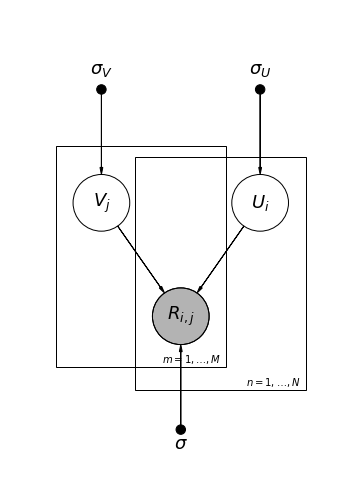

In [7]:
pgm = (PGM()
    .with_plate(Plate(r"$m = 1, \ldots, M$")
        .with_nodes(
            Data(r"$R_{i, j}$", xy=(1.5, 1.5)),
            Param(r"$V_j$", above_l="R_ij", shift_x=-0.4)))
    .with_plate(Plate(r"$n = 1, \ldots, N$")
        .with_nodes(
            "R_ij",
            Param(r"$U_i$", above_r="R_ij", shift_x=0.4)))
    .with_nodes(
        HyperParam(r"$\sigma_V$", above="V_j"),
        HyperParam(r"$\sigma_U$", above="U_i"),
        HyperParam(r"$\sigma$", below="R_ij"))
).build()
pgm.render();

## Classic Wet Grass Example

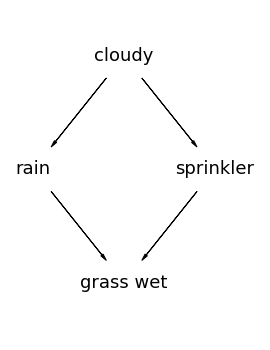

In [8]:
pgm = (PGM(node_ec="none")
    .with_nodes(
        Node("grass wet", xy=(1.0, 0.5)),
        Param("rain", above_l="grass wet", shift_x=-0.5),
        Param("sprinkler", above_r="grass wet", shift_x=0.5),
        Param("cloudy", above_r="rain", shift_x=0.5, of=["rain", "sprinkler"]))
).build()
pgm.render();

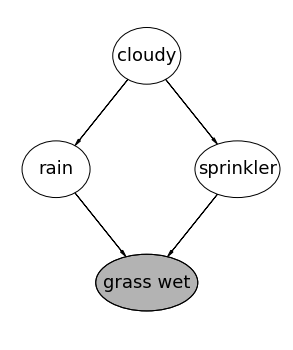

In [9]:
pgm = (PGM()
    .with_nodes(
        Data("grass wet", xy=(1.2, 0.5), aspect=1.8),
        Param("rain", above_l="grass wet", shift_x=-0.5, aspect=1.2),
        Param("sprinkler", above_r="grass wet", shift_x=0.5, aspect=1.5),
        Param("cloudy", above_r="rain", shift_x=0.5,
              of=["rain", "sprinkler"], aspect=1.2))
).build()
pgm.render();

# State Space Model (SSM)

From [Särkkä, 2013](https://users.aalto.fi/~ssarkka/pub/cup_book_online_20131111.pdf).

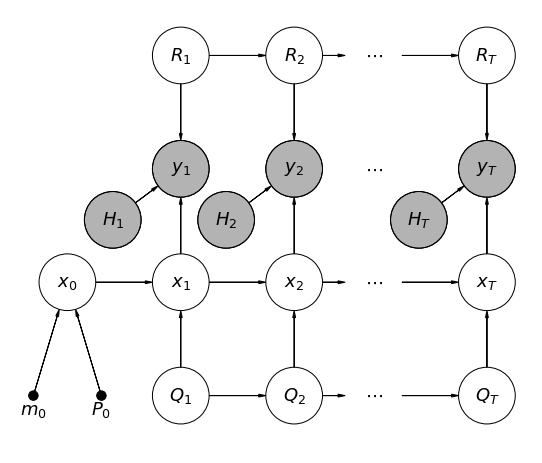

In [12]:
X_offsets = dict(shift_x=0.4, shift_y=-0.15)
pgm = (PGM(horizontal_offset=1)
    .with_nodes(  # Responses
        Data(r"$y_1$", xy=(1.5, 2.5)),
        Data(r"$y_2$", right_of="y_1"),
        Text(r"$\cdots$", name="y_dots", right_of="y_2", shift_x=-0.3),
        Data(r"$y_T$", right_of="y_dots"))
    .with_nodes(  # Design matrix
        Data(r"$H_1$", left_of_b="y_1", **X_offsets)
            .with_edges_to("y_1"),
        Data(r"$H_2$", left_of_b="y_2", **X_offsets)
            .with_edges_to("y_2"),
        Data(r"$H_T$", left_of_b="y_T", **X_offsets)
            .with_edges_to("y_T"))
    .with_nodes(  # State
        Param(r"$x_0$", left_of="x_1"),
        Param(r"$x_1$", below="y_1", of=["y_1", "x_2"]),
        Param(r"$x_2$", below="y_2", of=["y_2", "x_dots"]),
        Text(r"$\cdots$", name="x_dots", below="y_dots")
            .with_edges_to("x_T"),
        Param(r"$x_T$", below="y_T"))
    .with_nodes(  # Transition dynamics
        HyperParam(r"$m_0$", below_l="x_0"),
        HyperParam(r"$P_0$", below_r="x_0"),
        Param(r"$Q_1$", below="x_1", of=["x_1", "Q_2"]),
        Param(r"$Q_2$", below="x_2", of=["x_2", "Q_dots"]),
        Text(r"$\cdots$", name="Q_dots", right_of="Q_2", shift_x=-0.3)
            .with_edges_to("Q_T"),
        Param(r"$Q_T$", below="x_T", of=["x_T"]))
    .with_nodes(  # Measurement noise
        Param(r"$R_1$", above="y_1", of=["y_1", "R_2"]),
        Param(r"$R_2$", above="y_2", of=["y_2", "R_dots"]),
        Text(r"$\cdots$", name="R_dots", right_of="R_2", shift_x=-0.3)
            .with_edges_to("R_T"),
        Param(r"$R_T$", above="y_T"))
).build()
pgm.render();